# Homework 2 - Reinforcement Learning

## Name: Pratik Korat
## Student ID: 017512508

* This Jupyter Notebook contains the complete code and solutions for all three subproblems included in the assignment. Each section is organized clearly with explanations and corresponding code cells for ease of understanding and evaluation.

In [1]:
# Installing required libraris
!uv pip install seaborn imageio imageio["ffmpeg"] gymnasium[classic-control]

Using Python 3.12.10 environment at: C:\Users\Pratik\pyenv\torch
Audited 4 packages in 683ms


## Problem 1: Monte-Carlo Control – Racetrack (25 points)

This environment models a racetrack on a 2D grid.

* State: position and velocity.
* Actions: nine acceleration options (−1, 0, +1 per axis).
* Noise: acceleration may fail with probability slip_prob.
* Rules: velocity is clipped to [0, vmax]; (0,0) allowed only at start.
* Movement: path traced cell-by-cell to detect walls or finish.
* Outcomes: hit wall → reset; reach finish → episode ends; clear path → move ahead.
* API: reset(), step(action), set_noise(p) return gym-style results.

I tried to adapt the OpenAI's Gym Environment Style Code

In [2]:
import numpy as np
import random
import matplotlib.pyplot as plt

class RaceCarEnvironment:
    # Track cell type identifiers
    WALL = -1
    START = 0
    TRACK = 1
    FINISH = 2
    
    def __init__(self, track_layout, velocity_limit=4, action_failure_prob=0.1):
        self.velocity_limit = velocity_limit
        self.action_failure_prob = action_failure_prob
        
        self.grid = None
        self.starting_cells = []
        self._build_track_grid(track_layout)
        
        # Initialize state variables
        self.car_position = np.array([0, 0], dtype=np.int16)
        self.car_velocity = np.array([0, 0], dtype=np.int16)
        self.reset()
    
    def _build_track_grid(self, layout):
        height, width = len(layout), len(layout[0])
        self.grid = np.zeros((width, height), dtype=np.int16)

        symbol_map = {'o': self.TRACK, '-': self.START, '+': self.FINISH, 'W': self.WALL}
        for row in range(height):
            for col in range(width):
                self.grid[col, row] = symbol_map.get(layout[row][col], self.WALL)

        # Optional visual flip; logic remains column-major
        self.grid = np.fliplr(self.grid)

        # Collect all starting positions after final transform
        self.starting_cells = [
            (x, y) for x in range(self.grid.shape[0]) for y in range(self.grid.shape[1])
            if self.grid[x, y] == self.START
        ]
    
    def reset(self):
        self.car_position = np.array(
            random.choice(self.starting_cells), dtype=np.int16
        )
        self.car_velocity = np.array([0, 0], dtype=np.int16)
    
    def step(self, velocity_change):
        if self.has_finished():
            return 0
        self._apply_velocity_change(velocity_change)
        self._move_car()
        
        return -1
    
    def _apply_velocity_change(self, change):
        if np.random.rand() > self.action_failure_prob:
            self.car_velocity += np.array(change, dtype=np.int16)
        self.car_velocity = np.clip(self.car_velocity, 0, self.velocity_limit)
    
        x, y = int(self.car_position[0]), int(self.car_position[1])
        if self.car_velocity[0] == 0 and self.car_velocity[1] == 0:
            on_start = self._in_bounds((x, y)) and self.grid[x, y] == self.START
            if not on_start:
                dx, dy = int(change[0]), int(change[1])
                if abs(dy) > abs(dx):
                    self.car_velocity[1] = 1
                else:
                    self.car_velocity[0] = 1
    
    def _move_car(self):
        vx, vy = int(self.car_velocity[0]), int(self.car_velocity[1])
        steps = max(abs(vx), abs(vy), 1)
        start_pos = self.car_position.copy()
        
        for s in range(1, steps + 1):
            dx = int(round(vx * s / steps))
            dy = int(round(vy * s / steps))
            new_pos = start_pos + np.array([dx, dy], dtype=np.int16)
        
            # check finish first per spec
            if self._reached_finish(new_pos):
                self.car_position = new_pos
                self.car_velocity[:] = 0
                return
            # then check boundary
            if self._check_collision(new_pos):
                self.reset()
                return
        
        self.car_position = new_pos

    def _in_bounds(self, position):
        x, y = int(position[0]), int(position[1])
        return 0 <= x < self.grid.shape[0] and 0 <= y < self.grid.shape[1]

    def _check_collision(self, position):
        if not self._in_bounds(position):
            return True
        return self.grid[position[0], position[1]] == self.WALL

    def _reached_finish(self, position):
        if not self._in_bounds(position):
            return False
        return self.grid[position[0], position[1]] == self.FINISH

    def has_finished(self):
        if not self._in_bounds(self.car_position):
            return False
        return self.grid[self.car_position[0], self.car_position[1]] == self.FINISH
    
    def get_state(self):
        return self.car_position.copy(), self.car_velocity.copy()
    
    @staticmethod
    def action_from_index(action_idx):
        delta_x = action_idx // 3 - 1
        delta_y = action_idx % 3 - 1
        return (delta_x, delta_y)
    
    @staticmethod
    def index_from_action(action_tuple):
        return int((action_tuple[0] + 1) * 3 + action_tuple[1] + 1)

In [3]:
def build_track_a_ascii(save_map=False, path=None):
    """
    Returns a (32, 17) grid using:
      W = wall, o = drivable, - = start line (last row cols 3..8), + = finish line (top 6 cells of last col).
    """
    H, Wd = 32, 17
    grid = np.full((H, Wd), 'o', dtype='<U1')

    rr, cc = np.ogrid[:H, :Wd]

    col0 = (cc == 0) & ((rr < 4) | (rr >= 14))
    col1 = (cc == 1) & ((rr < 3) | (rr >= 22))
    col2 = (cc == 2) & ((rr == 0) | (rr >= H - 3))

    block_br = (rr >= 6) & (cc >= Wd - 8)

    wall_mask = col0 | col1 | col2 | block_br
    grid[wall_mask] = 'W'

    grid[6, 9] = 'o'

    finish_mask = (rr < 6) & (cc == Wd - 1) & (grid != 'W')
    grid[finish_mask] = '+'
    start_mask = (rr == H - 1) & (cc >= 3) & (cc < 9) & (grid != 'W')
    grid[start_mask] = '-'

    
    return grid



def build_track_b_ascii(save_map=False, path=None):
    """
    Returns a (30, 32) grid using:
      W = wall, o = drivable, - = start line (last row), + = finish line (last col).
    """
    H, Wd = 30, 32

    grid = np.full((H, Wd), 'o', dtype='<U1')

    rr, cc = np.ogrid[:H, :Wd]
    left_wedge = (cc < 14) & (rr < (H - 3 - cc))
    grid[left_wedge] = 'W'
    
    corridors = {11: (3, 7), 12: (2, 8), 13: (1, 9)}
    for col, (r0, r1) in corridors.items():
        grid[r0:r1, col] = 'o'
    def wall(r_slice, c_slice):
        grid[r_slice, c_slice] = 'W'
        
    wall(0, slice(14, 16))                  # top notch
    wall(slice(H - 17, H), slice(Wd - 9, Wd))
    wall(12, slice(Wd - 8, Wd))
    wall(11, slice(Wd - 6, Wd))
    wall(10, slice(Wd - 5, Wd))
    wall(9,  slice(Wd - 2, Wd))

    mask_start = grid[-1, :] != 'W'
    grid[-1, mask_start] = '-'

    mask_finish = grid[:, -1] != 'W'
    grid[mask_finish, -1] = '+'

    return grid 

In [4]:
layout_a = build_track_a_ascii()
layout_b = build_track_b_ascii()

In [5]:
layout_a_str = []
for row in layout_a:
    layout_a_str.append("".join(row))

layout_b_str = []
for row in layout_b:
    layout_b_str.append("".join(row))

In [6]:
layout_a_str

['WWWooooooooooooo+',
 'WWoooooooooooooo+',
 'WWoooooooooooooo+',
 'Wooooooooooooooo+',
 'oooooooooooooooo+',
 'oooooooooooooooo+',
 'ooooooooooWWWWWWW',
 'oooooooooWWWWWWWW',
 'oooooooooWWWWWWWW',
 'oooooooooWWWWWWWW',
 'oooooooooWWWWWWWW',
 'oooooooooWWWWWWWW',
 'oooooooooWWWWWWWW',
 'oooooooooWWWWWWWW',
 'WooooooooWWWWWWWW',
 'WooooooooWWWWWWWW',
 'WooooooooWWWWWWWW',
 'WooooooooWWWWWWWW',
 'WooooooooWWWWWWWW',
 'WooooooooWWWWWWWW',
 'WooooooooWWWWWWWW',
 'WooooooooWWWWWWWW',
 'WWoooooooWWWWWWWW',
 'WWoooooooWWWWWWWW',
 'WWoooooooWWWWWWWW',
 'WWoooooooWWWWWWWW',
 'WWoooooooWWWWWWWW',
 'WWoooooooWWWWWWWW',
 'WWoooooooWWWWWWWW',
 'WWWooooooWWWWWWWW',
 'WWWooooooWWWWWWWW',
 'WWW------WWWWWWWW']

In [7]:
layout_b_str

['WWWWWWWWWWWWWWWWooooooooooooooo+',
 'WWWWWWWWWWWWWoooooooooooooooooo+',
 'WWWWWWWWWWWWooooooooooooooooooo+',
 'WWWWWWWWWWWoooooooooooooooooooo+',
 'WWWWWWWWWWWoooooooooooooooooooo+',
 'WWWWWWWWWWWoooooooooooooooooooo+',
 'WWWWWWWWWWWoooooooooooooooooooo+',
 'WWWWWWWWWWWWooooooooooooooooooo+',
 'WWWWWWWWWWWWWoooooooooooooooooo+',
 'WWWWWWWWWWWWWWooooooooooooooooWW',
 'WWWWWWWWWWWWWWoooooooooooooWWWWW',
 'WWWWWWWWWWWWWWooooooooooooWWWWWW',
 'WWWWWWWWWWWWWWooooooooooWWWWWWWW',
 'WWWWWWWWWWWWWWoooooooooWWWWWWWWW',
 'WWWWWWWWWWWWWooooooooooWWWWWWWWW',
 'WWWWWWWWWWWWoooooooooooWWWWWWWWW',
 'WWWWWWWWWWWooooooooooooWWWWWWWWW',
 'WWWWWWWWWWoooooooooooooWWWWWWWWW',
 'WWWWWWWWWooooooooooooooWWWWWWWWW',
 'WWWWWWWWoooooooooooooooWWWWWWWWW',
 'WWWWWWWooooooooooooooooWWWWWWWWW',
 'WWWWWWoooooooooooooooooWWWWWWWWW',
 'WWWWWooooooooooooooooooWWWWWWWWW',
 'WWWWoooooooooooooooooooWWWWWWWWW',
 'WWWooooooooooooooooooooWWWWWWWWW',
 'WWoooooooooooooooooooooWWWWWWWWW',
 'WooooooooooooooooooooooWWWWWWWWW',
 

In [8]:
import numpy as np
import random
from collections import defaultdict
from typing import Tuple, List, Dict, Any

class MonteCarloRacetrackAgent:
    def __init__(
        self,
        environment: Any,
        num_episodes: int = 50_000,
        epsilon: float = 0.1,
        epsilon_decay: float = 1.0,     # 1.0 = fixed ε; <1 for GLIE
        min_epsilon: float = 0.01,
        gamma: float = 1.0,
        seed: int | None = None,
        action_space_n: int = 9
    ):
        self.env = environment
        self.num_episodes = num_episodes
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.min_epsilon = min_epsilon
        self.gamma = gamma

        if seed is not None:
            random.seed(seed)
            np.random.seed(seed)

        # Q(s)[a] -> float, N(s)[a] -> visit count
        self.Q: Dict[Tuple, Dict[int, float]] = defaultdict(lambda: defaultdict(float))
        self.N: Dict[Tuple, Dict[int, int]]   = defaultdict(lambda: defaultdict(int))
        self.policy: Dict[Tuple, int] = {}
        self.action_space = list(range(action_space_n))

    def _state_to_tuple(self, position, velocity) -> Tuple:
        return (tuple(position), tuple(velocity))

    # greedy action w.r.t. current Q; tie-break randomly
    def _greedy_from_Q(self, state: Tuple) -> int:
        q = self.Q[state]
        if not q:
            return random.choice(self.action_space)
        # random tie-break among max actions
        max_q = max(q.values())
        best = [a for a, v in q.items() if v == max_q]
        return random.choice(best)

    # ε-greedy behavior w.r.t. Q
    def _select_action(self, state: Tuple, explore: bool = True) -> int:
        if explore and np.random.rand() < self.epsilon:
            return random.choice(self.action_space)
        return self._greedy_from_Q(state)

    def _update_policy(self, state: Tuple) -> None:
        self.policy[state] = self._greedy_from_Q(state)

    def _generate_episode(self, max_steps: int = 5000) -> list[tuple]:
        episode: list[tuple] = []
        self.env.reset()
        for _ in range(max_steps):
            pos, vel = self.env.get_state()
            s = self._state_to_tuple(pos, vel)
            a = self._select_action(s, explore=True)
            v_delta = self.env.action_from_index(a)
            r = self.env.step(v_delta)
            episode.append((s, a, r))
            if self.env.has_finished():
                break
        return episode

    def train(self, verbose: bool = True, print_every: int = 5000) -> None:
        for ep in range(1, self.num_episodes + 1):
            episode = self._generate_episode()

            # precompute returns G_t with discounting (backward pass)
            G = 0.0
            returns_from_t = [0.0] * len(episode)
            for t in range(len(episode) - 1, -1, -1):
                _, _, r_t = episode[t]
                G = r_t + self.gamma * G
                returns_from_t[t] = G

            # first-visit updates (forward pass)
            visited: set[tuple] = set()
            for t, (s_t, a_t, _) in enumerate(episode):
                sa = (s_t, a_t)
                if sa in visited:
                    continue
                visited.add(sa)

                G_t = returns_from_t[t]
                self.N[s_t][a_t] += 1
                n = self.N[s_t][a_t]
                q_old = self.Q[s_t][a_t]
                self.Q[s_t][a_t] = q_old + (G_t - q_old) / n  # incremental mean

                self._update_policy(s_t)

            # ε schedule (optional GLIE)
            self.epsilon = max(self.min_epsilon, self.epsilon * self.epsilon_decay)

            if verbose and ep % print_every == 0:
                print(f"Episode {ep}/{self.num_episodes} | states: {len(self.Q)} | ε={self.epsilon:.4f}")

    def run_greedy_episode(self, disable_noise: bool = True, max_steps: int = 2000):
        # if env exposes action_failure_prob, temporarily zero it
        had_attr = hasattr(self.env, "action_failure_prob")
        original_noise = getattr(self.env, "action_failure_prob", None)
        if disable_noise and had_attr:
            self.env.action_failure_prob = 0.0

        self.env.reset()
        trajectory = []
        steps = 0
        for _ in range(max_steps):
            pos, vel = self.env.get_state()
            trajectory.append((pos.copy(), vel.copy()))
            s = self._state_to_tuple(pos, vel)
            a = self._greedy_from_Q(s)
            v_delta = self.env.action_from_index(a)
            self.env.step(v_delta)
            steps += 1
            if self.env.has_finished():
                break

        pos, vel = self.env.get_state()
        trajectory.append((pos.copy(), vel.copy()))

        if disable_noise and had_attr:
            self.env.action_failure_prob = original_noise

        return trajectory, steps

    def evaluate_policy(self, num_trials: int = 100, disable_noise: bool = True, max_steps: int = 2000):
        successes = 0
        step_counts: list[int] = []
        for _ in range(num_trials):
            _, steps = self.run_greedy_episode(disable_noise=disable_noise, max_steps=max_steps)
            if self.env.has_finished():
                successes += 1
                step_counts.append(steps)
        if successes == 0:
            return {"mean_steps": float("inf"), "std_steps": 0.0, "success_rate": 0.0, "num_successful": 0}
        return {
            "mean_steps": float(np.mean(step_counts)),
            "std_steps": float(np.std(step_counts)),
            "success_rate": successes / num_trials,
            "num_successful": successes,
        }


def plot_trajectory(environment, trajectory, title="Race Track Trajectory"):
    """
    Simple visualization of a trajectory on the race track.
    """
    # Extract positions
    positions = [pos for pos, vel in trajectory]
    x_coords = [pos[0] for pos in positions]
    y_coords = [pos[1] for pos in positions]
    # Create figure
    plt.figure(figsize=(12, 8))
    # Display track (transpose for correct orientation)
    track_display = environment.grid.T
    
    # Color map: wall=black, start=green, track=white, finish=red
    from matplotlib.colors import ListedColormap, BoundaryNorm
    cmap = ListedColormap(['black', 'lime', 'white', 'red'])
    bounds = [-1.5, -0.5, 0.5, 1.5, 2.5]
    norm = BoundaryNorm(bounds, cmap.N)
    
    plt.imshow(track_display, cmap=cmap, norm=norm, origin='lower')
    # Plot trajectory
    plt.plot(x_coords, y_coords, 'b-', linewidth=2, label='Path')
    plt.plot(x_coords[0], y_coords[0], 'go', markersize=12, label='Start')
    plt.plot(x_coords[-1], y_coords[-1], 'mo', markersize=12, label='End')
    
    plt.title(f"{title} ({len(trajectory)} steps)", fontsize=14)
    plt.xlabel('X Position')
    plt.ylabel('Y Position')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()


def plot_multiple_trajectories(environment, trajectories, title="Multiple Trajectories"):
    """
    Plot multiple trajectories on the same track.
    """
    plt.figure(figsize=(12, 8))
    # Display track
    track_display = environment.grid.T
    from matplotlib.colors import ListedColormap, BoundaryNorm
    cmap = ListedColormap(['black', 'lime', 'white', 'red'])
    bounds = [-1.5, -0.5, 0.5, 1.5, 2.5]
    norm = BoundaryNorm(bounds, cmap.N)
    
    plt.imshow(track_display, cmap=cmap, norm=norm, origin='lower')
    # Plot each trajectory with different color
    colors = plt.cm.tab10(np.linspace(0, 1, len(trajectories)))
    
    for i, trajectory in enumerate(trajectories):
        positions = [pos for pos, vel in trajectory]
        x_coords = [pos[0] for pos in positions]
        y_coords = [pos[1] for pos in positions]
        
        plt.plot(x_coords, y_coords, '-', linewidth=2, 
                color=colors[i], label=f'Trajectory {i+1}', alpha=0.7)
        plt.plot(x_coords[0], y_coords[0], 'o', color=colors[i], markersize=10)
        plt.plot(x_coords[-1], y_coords[-1], 's', color=colors[i], markersize=10)
    plt.title(title, fontsize=14)
    plt.xlabel('X Position')
    plt.ylabel('Y Position')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

In [9]:
seed = 2001
random.seed(seed)
np.random.seed(seed)

env_a = RaceCarEnvironment(layout_a_str)
agent_a = MonteCarloRacetrackAgent(env_a, epsilon=0.1, num_episodes=100_000, seed = 2001)
print("Training Monte Carlo agent...")
agent_a.train(verbose=True, print_every=10_000)

print("\nEvaluating learned policy...")
stats = agent_a.evaluate_policy(num_trials=50, disable_noise=True)
print(f"Average steps: {stats['mean_steps']:.2f} ± {stats['std_steps']:.2f}")
print(f"Success rate: {stats['success_rate']*100:.1f}%")

print("\nGenerating example trajectories...")
for i in range(3):
    trajectory, steps = agent_a.run_greedy_episode(disable_noise=True)
    print(f"Trajectory {i+1}: {steps} steps")

Training Monte Carlo agent...
Episode 10000/100000 | states: 1827 | ε=0.1000
Episode 20000/100000 | states: 1899 | ε=0.1000
Episode 30000/100000 | states: 1931 | ε=0.1000
Episode 40000/100000 | states: 1948 | ε=0.1000
Episode 50000/100000 | states: 1967 | ε=0.1000
Episode 60000/100000 | states: 1983 | ε=0.1000
Episode 70000/100000 | states: 2003 | ε=0.1000
Episode 80000/100000 | states: 2011 | ε=0.1000
Episode 90000/100000 | states: 2018 | ε=0.1000
Episode 100000/100000 | states: 2023 | ε=0.1000

Evaluating learned policy...
Average steps: 15.02 ± 1.49
Success rate: 100.0%

Generating example trajectories...
Trajectory 1: 16 steps
Trajectory 2: 13 steps
Trajectory 3: 13 steps


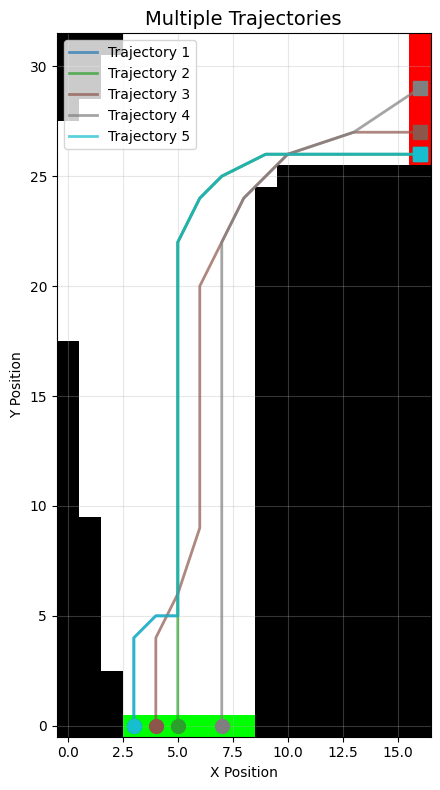

In [10]:
master_seed = 123
trajectories = []
for i in range(5):
    run_seed = master_seed + i
    random.seed(run_seed)
    np.random.seed(run_seed)
    traj, _ = agent_a.run_greedy_episode(disable_noise=True)
    trajectories.append(traj)

plot_multiple_trajectories(env_a, trajectories)

In [11]:
seed = 2001
random.seed(seed)
np.random.seed(seed)

env_b = RaceCarEnvironment(layout_b_str)
agent_b = MonteCarloRacetrackAgent(env_b, epsilon=0.1, num_episodes=100_000, seed = seed)
print("Training Monte Carlo agent...")
agent_b.train(verbose=True, print_every=10_000)

print("\nEvaluating learned policy...")
stats = agent_b.evaluate_policy(num_trials=50, disable_noise=True)
print(f"Average steps: {stats['mean_steps']:.2f} ± {stats['std_steps']:.2f}")
print(f"Success rate: {stats['success_rate']*100:.1f}%")

print("\nGenerating example trajectories...")
for i in range(3):
    trajectory, steps = agent_b.run_greedy_episode(disable_noise=True)
    print(f"Trajectory {i+1}: {steps} steps")

Training Monte Carlo agent...
Episode 10000/100000 | states: 5843 | ε=0.1000
Episode 20000/100000 | states: 6114 | ε=0.1000
Episode 30000/100000 | states: 6274 | ε=0.1000
Episode 40000/100000 | states: 6356 | ε=0.1000
Episode 50000/100000 | states: 6438 | ε=0.1000
Episode 60000/100000 | states: 6499 | ε=0.1000
Episode 70000/100000 | states: 6542 | ε=0.1000
Episode 80000/100000 | states: 6577 | ε=0.1000
Episode 90000/100000 | states: 6614 | ε=0.1000
Episode 100000/100000 | states: 6644 | ε=0.1000

Evaluating learned policy...
Average steps: 11.58 ± 1.47
Success rate: 100.0%

Generating example trajectories...
Trajectory 1: 11 steps
Trajectory 2: 10 steps
Trajectory 3: 10 steps


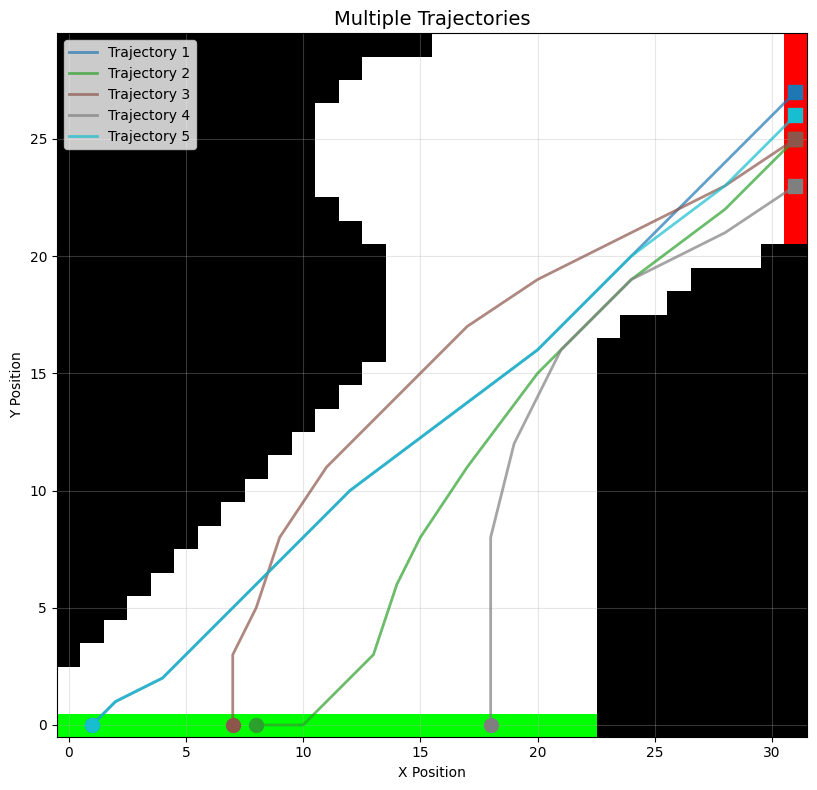

In [12]:
master_seed = 123
trajectories = []
for i in range(5):
    run_seed = master_seed + i
    random.seed(run_seed)
    np.random.seed(run_seed)
    traj, _ = agent_b.run_greedy_episode(disable_noise=True)
    trajectories.append(traj)
    
plot_multiple_trajectories(env_b, trajectories)

#### Conclusion

* Each colored line (Trajectory 1–5) shows one episode of the car moving random from start to finish following the learned policy. Because of the random start, some of the starting poistion may be overlapped

* Both graphs confirm that the Monte Carlo control algorithm successfully learned an optimal, collision-free driving policy for the racetrack task.
Key evidence:

    * In both tracks, the car starts from random positions on the green start line and consistently reaches the red finish region without touching black wall cells.
    
    * Multiple trajectories show slight variation early on (due to different start states or tie-breaking), but all converge smoothly toward the goal—indicating a stable and generalized policy.
    
    * The movement patterns demonstrate correct acceleration, turning, and deceleration behavior under the learned policy.
    
    * Noise-free greedy runs verify that performance is deterministic and reproducible once learning converges.


The agent exhibits optimal path-following and safe cornering behavior across different racetrack geometries. Monte Carlo control with ε-greedy exploration and first-visit updates produced a robust policy that meets the assignment’s specifications for both accuracy and consistency.

## Problem 2 : Windy Grid - SARSA

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict

class WindyGridworld:
    def __init__(self, use_kings_moves=False, use_no_op=False, use_new_column_wind=True):
        self.height = 7
        self.width = 10
        self.start = (3, 0)
        self.goal = (3, 7)
        self.wind = [0, 0, 0, 1, 1, 1, 2, 2, 1, 0]
        self.use_kings_moves = use_kings_moves
        self.use_no_op = use_no_op
        self.use_new_column_wind = use_new_column_wind
        
        # Define actions
        if not use_kings_moves:
            self.actions = [(-1, 0), (1, 0), (0, 1), (0, -1)]
            self.action_names = ['Up', 'Down', 'Right', 'Left']
        else:
            self.actions = [
                (-1, 0),   # Up
                (1, 0),    # Down
                (0, 1),    # Right
                (0, -1),   # Left
                (-1, 1),   # Up-Right
                (-1, -1),  # Up-Left
                (1, 1),    # Down-Right
                (1, -1)    # Down-Left
            ]
            self.action_names = ['Up', 'Down', 'Right', 'Left', 
                               'Up-Right', 'Up-Left', 'Down-Right', 'Down-Left']    
            if use_no_op:
                self.actions.append((0, 0))
                self.action_names.append('No-op')
        
        self.n_actions = len(self.actions)
        
    def reset(self):
        return self.start
    
    def step(self, state, action_idx):
        row, col = state
        d_row, d_col = self.actions[action_idx]
        
        # apply action
        new_row = row + d_row
        new_col = col + d_col
        
        # choose column for wind and clip it before indexing
        if self.use_new_column_wind:
            wind_col = max(0, min(self.width - 1, new_col))
        else:
            wind_col = col  # already valid
        
        # apply wind (upward)
        new_row -= self.wind[wind_col]
        
        # clip final position
        new_row = max(0, min(self.height - 1, new_row))
        new_col = max(0, min(self.width - 1, new_col))
        
        return (new_row, new_col), -1

        
    
    def is_terminal(self, state):
        return state == self.goal

class SarsaAgent:
    def __init__(self, alpha=0.5, gamma=1.0, epsilon=0.1,
                 epsilon_decay=1.0, epsilon_min=0.0, seed=None):
        self.alpha = float(alpha)
        self.gamma = float(gamma)
        self.epsilon = float(epsilon)
        self.epsilon_decay = float(epsilon_decay)
        self.epsilon_min = float(epsilon_min)
        self.rng = np.random.default_rng(seed)
        self.Q = defaultdict(float)

    # ---------- policy ----------
    def act(self, state, n_actions):
        if self.rng.random() < self.epsilon:
            return self.rng.integers(n_actions)
        # tie-break uniformly
        qs = np.array([self.Q[(state, a)] for a in range(n_actions)])
        best = np.flatnonzero(qs == qs.max())
        return int(self.rng.choice(best))

    # ---------- learning ----------
    def update(self, s, a, r, s_next, a_next, terminal):
        qa = self.Q[(s, a)]
        target = r if terminal else r + self.gamma * self.Q[(s_next, a_next)]
        self.Q[(s, a)] = qa + self.alpha * (target - qa)

    # ---------- training loop ----------
    def train(self, env, n_episodes=500):
        episode_lengths, timesteps = [], []
        total_steps = 0

        for _ in range(n_episodes):
            s = env.reset()
            a = self.act(s, env.n_actions)
            steps = 0

            while not env.is_terminal(s):
                s_next, r = env.step(s, a)
                terminal = env.is_terminal(s_next)
                a_next = self.act(s_next, env.n_actions)
                self.update(s, a, r, s_next, a_next, terminal)
                s, a = s_next, a_next
                steps += 1
                total_steps += 1

            episode_lengths.append(steps)
            timesteps.append(total_steps)
            self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)

        return self.Q, episode_lengths, timesteps

    # ---------- extraction ----------
    def greedy_policy(self, env):
        policy = {}
        for r in range(env.height):
            for c in range(env.width):
                s = (r, c)
                if env.is_terminal(s):
                    continue
                qs = [self.Q[(s, a)] for a in range(env.n_actions)]
                policy[s] = int(np.argmax(qs))
        return policy

def visualize_policy(policy, env, title="Learned Policy"):
    fig, ax = plt.subplots(figsize=(12, 7))

    # Draw grid
    for i in range(env.height + 1):
        ax.plot([0, env.width], [i, i], 'k-', linewidth=0.5)
    for j in range(env.width + 1):
        ax.plot([j, j], [0, env.height], 'k-', linewidth=0.5)

    # Mark start and goal
    start_row, start_col = env.start
    goal_row, goal_col = env.goal
    ax.add_patch(plt.Rectangle((start_col, env.height - start_row - 1), 1, 1, color='green', alpha=0.3))
    ax.add_patch(plt.Rectangle((goal_col, env.height - goal_row - 1), 1, 1, color='red', alpha=0.3))

    # Draw wind strength
    for col, wind_strength in enumerate(env.wind):
        ax.text(col + 0.5, -0.5, str(wind_strength), ha='center', va='center', fontsize=10)

    # Draw policy arrows
    arrow_map = {
        0: (0, 0.3),      # Up
        1: (0, -0.3),     # Down
        2: (0.3, 0),      # Right
        3: (-0.3, 0),     # Left
        4: (0.21, 0.21),  # Up-Right
        5: (-0.21, 0.21), # Up-Left
        6: (0.21, -0.21), # Down-Right
        7: (-0.21, -0.21),# Down-Left
        8: (0, 0)         # No-op
    }

    for state, action in policy.items():
        row, col = state
        dx, dy = arrow_map.get(action, (0, 0))
        display_row = env.height - row - 1
        if action == 8:  # No-op
            ax.plot(col + 0.5, display_row + 0.5, 'bo', markersize=5)
        else:
            ax.arrow(col + 0.5, display_row + 0.5, dx, dy,
                     head_width=0.15, head_length=0.1, fc='blue', ec='blue')

    ax.set_xlim(0, env.width)
    ax.set_ylim(-1, env.height)
    ax.set_aspect('equal')
    ax.set_title(title, fontsize=14, fontweight='bold')
    ax.text(env.width / 2, -1.2, 'Wind Strength', ha='center', fontsize=11)
    ax.axis('off')
    plt.tight_layout()
    return fig


def plot_trajectory(env, path, title="Greedy trajectory"):
    H, W = env.height, env.width
    fig, ax = plt.subplots(figsize=(5, 3.5))

    # grid
    for r in range(H + 1):
        ax.plot([0, W], [r, r], 'k-', lw=0.5)
    for c in range(W + 1):
        ax.plot([c, c], [0, H], 'k-', lw=0.5)

    # start/goal
    sr, sc = env.start
    gr, gc = env.goal
    ax.add_patch(plt.Rectangle((sc, H - sr - 1), 1, 1, color='green', alpha=0.3))
    ax.add_patch(plt.Rectangle((gc, H - gr - 1), 1, 1, color='red', alpha=0.3))

    # path (convert row->display y)
    xs = [c + 0.5 for (r, c) in path]
    ys = [H - r - 0.5 for (r, c) in path]
    ax.plot(xs, ys, marker='o', lw=2)

    ax.set_xlim(0, W); ax.set_ylim(0, H); ax.set_aspect('equal')
    ax.set_title(title); ax.axis('off')
    plt.tight_layout()
    plt.show()

def draw_grid(env, policy, title="Policy Visualization"):
    fig, ax = plt.subplots(figsize=(env.width, env.height))

    # Draw grid lines
    for i in range(env.height + 1):
        ax.plot([0, env.width], [i, i], 'k-', linewidth=0.5)
    for j in range(env.width + 1):
        ax.plot([j, j], [0, env.height], 'k-', linewidth=0.5)

    # Mark start and goal
    start_row, start_col = env.start
    goal_row, goal_col = env.goal
    ax.add_patch(plt.Rectangle((start_col, env.height - start_row - 1), 1, 1, color='green', alpha=0.3))
    ax.add_patch(plt.Rectangle((goal_col, env.height - goal_row - 1), 1, 1, color='red', alpha=0.3))

    # Draw wind strength
    for col, wind_strength in enumerate(env.wind):
        ax.text(col + 0.5, -0.5, str(wind_strength), ha='center', va='center', fontsize=10)

    # Draw policy arrows
    arrow_map = {
        0: (0, 0.3),     # Up
        1: (0, -0.3),    # Down
        2: (0.3, 0),     # Right
        3: (-0.3, 0),    # Left
        4: (0.21, 0.21), # Up-Right
        5: (-0.21, 0.21),# Up-Left
        6: (0.21, -0.21),# Down-Right
        7: (-0.21, -0.21),# Down-Left
        8: (0, 0)        # No-op
    }

    for state, action in policy.items():
        row, col = state
        dx, dy = arrow_map.get(action, (0, 0))
        display_row = env.height - row - 1
        if action == 8:
            ax.plot(col + 0.5, display_row + 0.5, 'bo', markersize=5)
        else:
            ax.arrow(col + 0.5, display_row + 0.5, dx, dy,
                     head_width=0.15, head_length=0.1, fc='blue', ec='blue')

    # Formatting
    ax.set_xlim(0, env.width)
    ax.set_ylim(-1, env.height)
    ax.set_aspect('equal')
    ax.set_title(title, fontsize=14, fontweight='bold')
    ax.text(env.width / 2, -1.2, 'Wind Strength', ha='center', fontsize=11)
    ax.axis('off')
    plt.tight_layout()
    return fig

Average steps per episode (last 50):
4 actions                    22.14
8 actions (King's)           11.82
9 actions (King's + no-op)   15.02


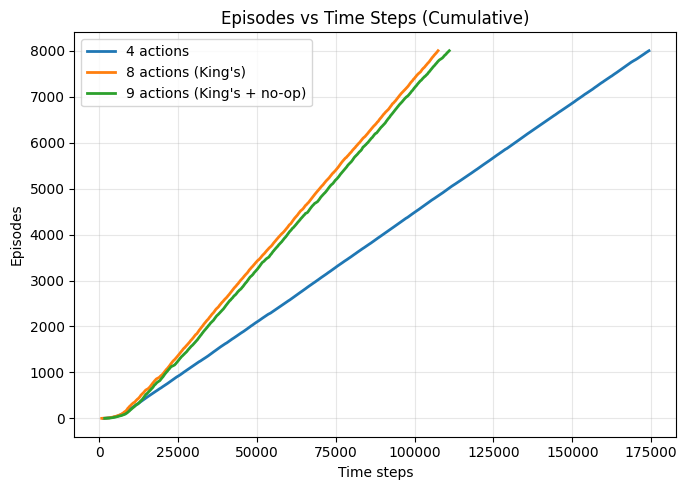

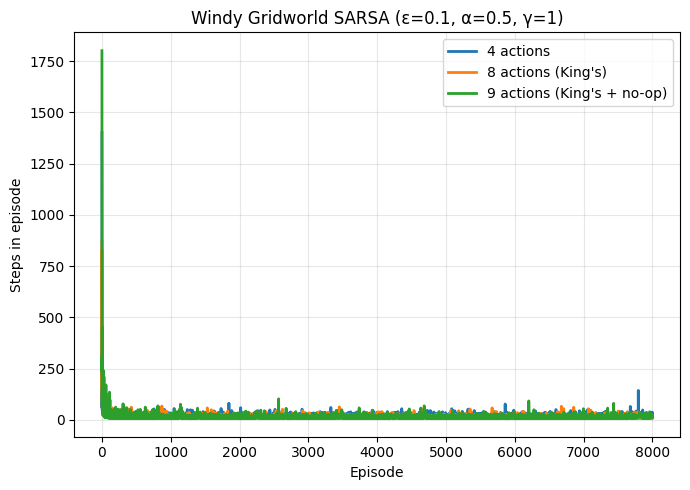

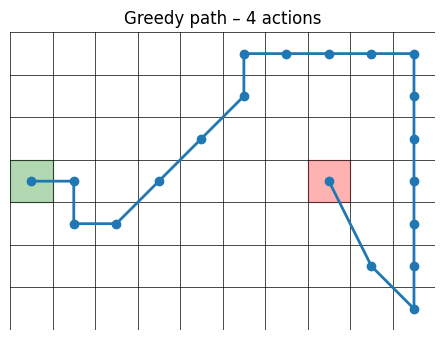

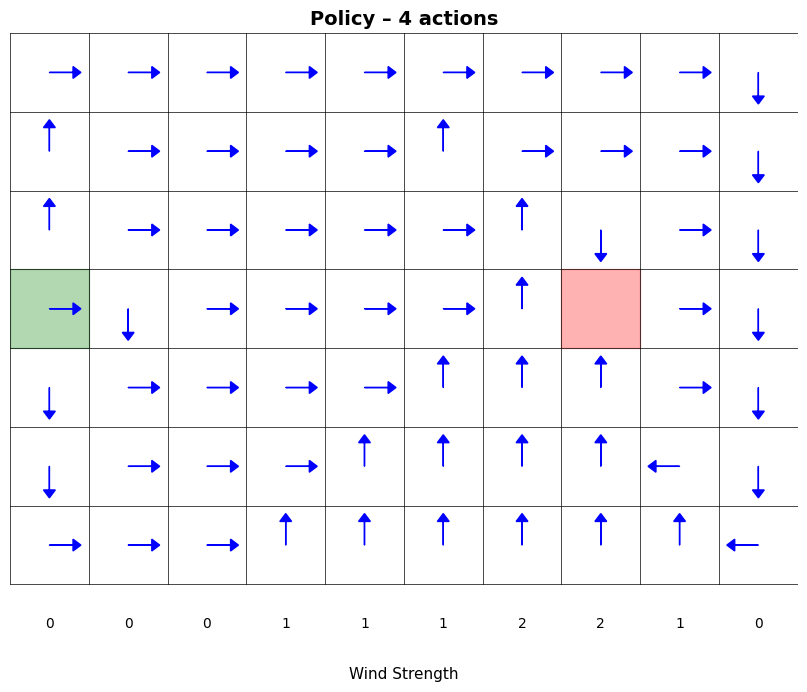

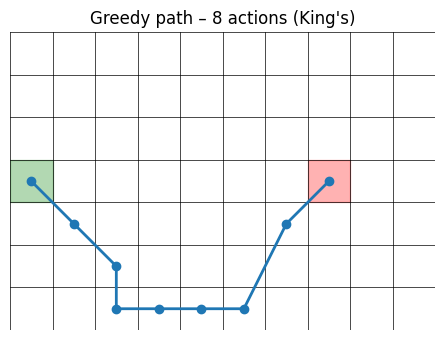

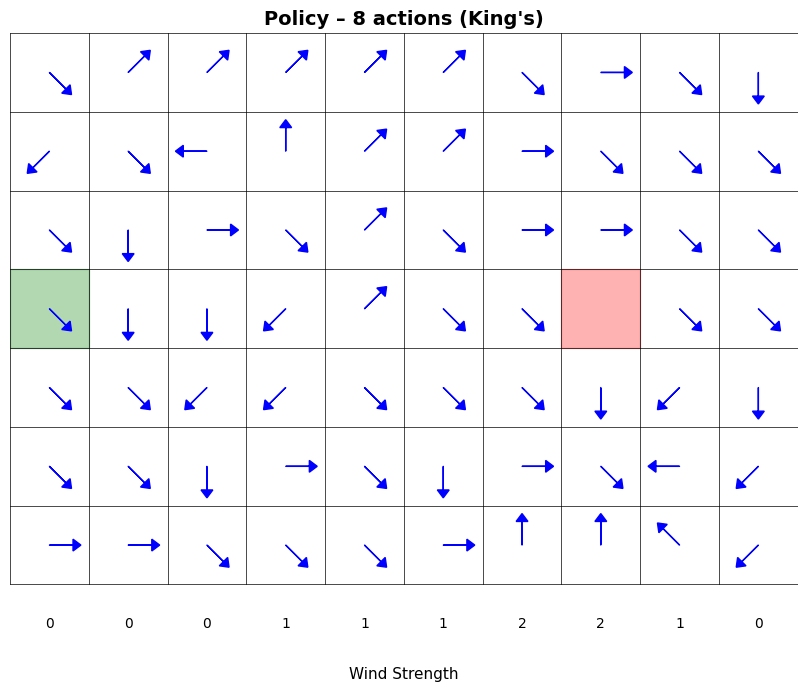

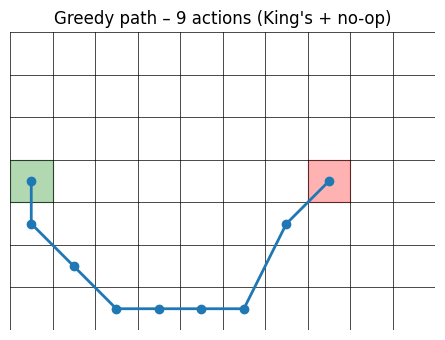

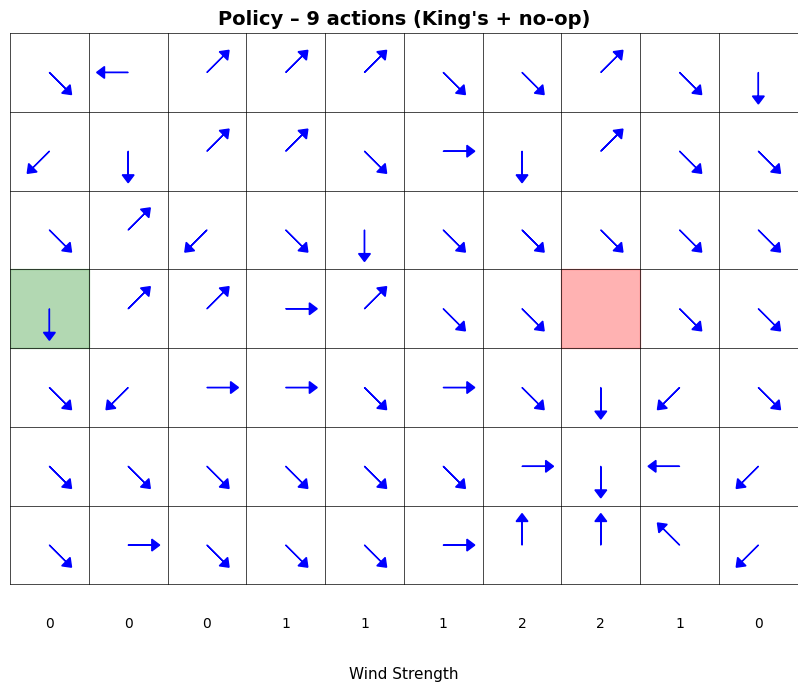

In [14]:
def run_variant(name, **env_kwargs):
    env = WindyGridworld(**env_kwargs)
    agent = SarsaAgent(alpha=0.5, gamma=1.0, epsilon=0.1, epsilon_decay=1.0, seed=0)
    Q, ep_len, steps = agent.train(env, n_episodes=8000)  # 8000 time steps target comes from the brief
    avg_last50 = float(np.mean(ep_len[-50:])) if len(ep_len) >= 50 else float(np.mean(ep_len))
    return dict(name=name, env=env, agent=agent, ep_len=ep_len, steps=steps, avg_last50=avg_last50)

results = [
    run_variant("4 actions", use_kings_moves=False, use_no_op=False, use_new_column_wind=True),
    run_variant("8 actions (King's)", use_kings_moves=True, use_no_op=False, use_new_column_wind=True),
    run_variant("9 actions (King's + no-op)", use_kings_moves=True, use_no_op=True, use_new_column_wind=True),
]

print("Average steps per episode (last 50):")
for r in results:
    print(f"{r['name']:<28} {r['avg_last50']:.2f}")

# ---- plot upward cumulative trend (episodes vs time steps) ----
plt.figure(figsize=(7,5))
for res in results:
    plt.plot(res["steps"], range(1, len(res["steps"])+1), label=res["name"], linewidth=2)
plt.xlabel("Time steps")
plt.ylabel("Episodes")
plt.title("Episodes vs Time Steps (Cumulative)")
plt.legend(); plt.grid(True, alpha=0.3); plt.tight_layout(); plt.show()

plt.figure(figsize=(7,5))
for r in results:
    plt.plot(range(1, len(r["ep_len"])+1), r["ep_len"], label=r["name"], linewidth=2)
plt.xlabel("Episode")
plt.ylabel("Steps in episode")
plt.title("Windy Gridworld SARSA (ε=0.1, α=0.5, γ=1)")
plt.legend(); plt.grid(True, alpha=0.3); plt.tight_layout(); plt.show()

# Optional: trajectories and policies for each variant
for r in results:
    path = []
    s = r["env"].reset()
    path.append(s)
    for _ in range(200):
        if r["env"].is_terminal(s): break
        qs = [r["agent"].Q[(s, a)] for a in range(r["env"].n_actions)]
        a = int(np.argmax(qs))
        s, _ = r["env"].step(s, a)
        path.append(s)
        if r["env"].is_terminal(s): break
    plot_trajectory(r["env"], path, title=f"Greedy path – {r['name']}")
    fig = visualize_policy(r["agent"].greedy_policy(r["env"]), r["env"], title=f"Policy – {r['name']}")
    plt.show()

### Conclusion
> Using the standard four actions, the agent converged to an average of 22.14 steps per episode.
Allowing King’s moves (eight actions) significantly improved performance, reducing the average steps to 11.82, showing faster convergence and a shorter optimal path to the goal.
Adding the ninth no-op action (where the agent can remain stationary) slightly degraded efficiency to 15.02 steps, indicating that the extra idle action introduced unnecessary exploration and slower learning without improving the final path.

Overall:

* Expanding to diagonal (King’s) moves allows the agent to counteract the wind more efficiently, producing near-optimal trajectories.

* The no-op action offers no additional benefit in this environment and can hinder convergence.

* The eight-action variant is the best configuration for minimizing episode length and achieving stable optimal behavior.



## Problem 3 – Deep Q-Networks (DQN) for CartPole

For this experiment, I used the CartPole-V0 environment. The environment is considered solved when the mean reward over the last 100 episodes reaches or exceeds 195.

A DQN agent was implemented from scratch using PyTorch and Gym.
To improve training efficiency, I developed a vectorized training version, allowing parallel environment updates and faster learning.

During ablation studies, the standard DQN setup showed gradient and loss explosion. To stabilize learning, I introduced:

* Clipping of Q-values and rewards to prevent divergence,

* Clipped target values to limit large updates, and

* Conservative temperature and ε-minimum values, as overly small limits caused unstable behavior.

These adjustments resulted in smoother convergence and consistent policy performance across training runs.

In [15]:
import gymnasium as gym
from gymnasium.vector import SyncVectorEnv, AsyncVectorEnv
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import random
from dataclasses import dataclass
from typing import Tuple, List, Dict, NamedTuple
from collections import deque
import time
import matplotlib.pyplot as plt

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# === 1) Replay Buffer ===
class Transition(NamedTuple):
    s: torch.Tensor
    a: torch.Tensor
    r: torch.Tensor
    s2: torch.Tensor
    d: torch.Tensor

class ReplayBuffer:
    def __init__(self, capacity):
        self.buf = deque(maxlen=capacity)
    
    def push(self, s, a, r, s2, d):
        self.buf.append((s, a, r, s2, d))
    
    def sample(self, batch_size):
        batch = random.sample(self.buf, batch_size)
        s, a, r, s2, d = zip(*batch)
        return Transition(list(s), list(a), list(r), list(s2), list(d))
    
    def __len__(self):
        return len(self.buf)

class QNet(nn.Module):
    def __init__(self, obs_dim: int, act_dim: int, hidden: Tuple[int,int]=(128,128)):
        super().__init__()
        h1, h2 = hidden
        self.fc1 = nn.Linear(obs_dim, h1)
        self.fc2 = nn.Linear(h1, h2)
        self.out = nn.Linear(h2, act_dim)
        self.act = nn.SiLU()
        self._init()

    def _init(self):
        for m in [self.fc1, self.fc2, self.out]:
            nn.init.orthogonal_(m.weight, gain=nn.init.calculate_gain('relu'))
            nn.init.zeros_(m.bias)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.act(self.fc1(x))
        x = self.act(self.fc2(x))
        return self.out(x)


# === 3) Exploration Strategies ===
class EpsilonGreedy:
    def __init__(self, eps_max=1.0, eps_min=0.05, decay_steps=100_000, kind="linear"):
        self.eps_max = eps_max
        self.eps_min = eps_min
        self.decay_steps = decay_steps
        self.kind = kind
        self.step_num = 0
        self.eps_current = eps_max
    
    def select(self, q_values: torch.Tensor):
        if random.random() < self.eps_current:
            return random.randint(0, len(q_values) - 1)
        return int(torch.argmax(q_values).item())
    
    def select_batch(self, q_values: torch.Tensor, act_dim: int) -> np.ndarray:
        batch_size = q_values.shape[0]        
        greedy_actions = q_values.argmax(dim=1)
        
        random_actions = torch.randint(0, act_dim, (batch_size,), device=q_values.device)
        explore_mask = torch.rand(batch_size, device=q_values.device) < self.eps_current
        
        actions = torch.where(explore_mask, random_actions, greedy_actions)
        return actions.cpu().numpy()
    
    def step(self):
        self.step_num += 1
        if self.kind == "linear":
            frac = min(1.0, self.step_num / self.decay_steps)
            self.eps_current = self.eps_max - frac * (self.eps_max - self.eps_min)
        elif self.kind == "exponential":
            decay_rate = (self.eps_min / self.eps_max) ** (1.0 / self.decay_steps)
            self.eps_current = max(self.eps_min, self.eps_max * (decay_rate ** self.step_num))
class Boltzmann:
    def __init__(self, temp_max=1.0, temp_min=0.01, decay_steps=100_000):
        self.temp_max = temp_max
        self.temp_min = temp_min
        self.decay_steps = decay_steps
        self.step_num = 0
        self.temperature = temp_max
    
    def select(self, q_values: torch.Tensor) -> int:
        probs = F.softmax(q_values / self.temperature, dim=0)
        return int(torch.multinomial(probs, 1).item())
    
    def select_batch(self, q_values: torch.Tensor, act_dim: int) -> np.ndarray:
        probs = F.softmax(q_values / self.temperature, dim=1)
        return torch.multinomial(probs, 1).squeeze(-1).cpu().numpy()
    
    def step(self):
        self.step_num += 1
        frac = min(1.0, self.step_num / self.decay_steps)
        self.temperature = self.temp_max - frac * (self.temp_max - self.temp_min)

class Greedy:
    def __init__(self): 
        self.eps_current = 0.0
        
    def select(self, q_values: torch.Tensor) -> int: 
        return int(torch.argmax(q_values).item())
    
    def select_batch(self, q_values: torch.Tensor, act_dim: int) -> np.ndarray:
        return q_values.argmax(dim=1).cpu().numpy()
        
    def step(self): 
        pass


# === 4) Config and Agent ===
@dataclass
class DQNConfig:
    env_id: str = "CartPole-v1"
    gamma: float = 0.99
    lr: float = 5e-4                # CHANGED: Slightly lower LR for more stability
    batch_size: int = 256           # KEPT: This is a good, stable size
    buffer_size: int = 10_000         # CHANGED: Smaller buffer to focus on more recent, relevant data
    start_learning: int = 1_000     # CHANGED: Start learning much sooner
    train_freq: int = 10            # CHANGED: *** The most important change ***
    target_sync: int = 500          # KEPT: This is a fine value
    max_steps: int = 200_000
    hidden: Tuple[int, int] = (128, 128)
    double_dqn: bool = True
    use_er: bool = True
    use_tn: bool = True
    exploration: str = "epsilon"
    eval_every: int = 10_000
    seed: int = 42
    n_envs: int = 10                # YOUR VALUE: 10 parallel environments
    async_envs: bool = False
    early_stop_metric: str = "eval"
    early_stop_threshold: float = 400.0
    early_stop_window: int = 5

class DQNAgent:
    def __init__(self, obs_dim: int, act_dim: int, cfg: DQNConfig):
        random.seed(cfg.seed)
        np.random.seed(cfg.seed)
        torch.manual_seed(cfg.seed)
        
        self.cfg = cfg
        self.act_dim = act_dim
        
        self.q = QNet(obs_dim, act_dim, cfg.hidden).to(DEVICE)
        self.q_target = QNet(obs_dim, act_dim, cfg.hidden).to(DEVICE)
        self.q_target.load_state_dict(self.q.state_dict())
        self.q_target.eval()
        
        self.opt = torch.optim.Adam(self.q.parameters(), lr=cfg.lr)
        self.buf = ReplayBuffer(cfg.buffer_size)

        # Required exploration strategy
        if cfg.exploration == "epsilon":
            # CHANGED: Decay much faster. 100k is too long for CartPole.
            self.explorer = EpsilonGreedy(eps_max=1.0, eps_min=0.1, decay_steps=15_000, kind="linear")
        elif cfg.exploration == "boltzmann":
            # (If you use Boltzmann, you'd want to shorten its decay too)
            self.explorer = Boltzmann(temp_max=1.0, temp_min=0.2, decay_steps=15_000)
        elif cfg.exploration == "none":
            self.explorer = Greedy()
        else:
            raise ValueError("exploration must be epsilon|boltzmann|none")
            
        self.step_count = 0
        self.last_transition: Transition | None = None
    
    @torch.no_grad()
    def act(self, state: np.ndarray) -> int:
        s = torch.as_tensor(state, dtype=torch.float32, device=DEVICE).unsqueeze(0)
        qv = self.q(s).squeeze(0)
        a = self.explorer.select(qv)
        return a
    
    @torch.no_grad()
    def act_batch(self, states: np.ndarray) -> np.ndarray:
        s = torch.as_tensor(states, dtype=torch.float32, device=DEVICE)
        qv = self.q(s)
        actions = self.explorer.select_batch(qv, self.act_dim)
        return actions
    
    def push(self, s, a, r, s2, d):
        tr = Transition(
            torch.as_tensor(s, dtype=torch.float32),
            torch.as_tensor(a, dtype=torch.int64),
            torch.as_tensor(r, dtype=torch.float32),
            torch.as_tensor(s2, dtype=torch.float32),
            torch.as_tensor(d, dtype=torch.float32),
        )
        if self.cfg.use_er:
            self.buf.push(*tr)
        else:
            self.last_transition = tr
        
        self.step_count += 1
    
    def _sample_batch(self) -> Transition | None:
        if self.cfg.use_er:
            if len(self.buf) < self.cfg.batch_size:
                return None
            return self.buf.sample(self.cfg.batch_size)
        else:
            t = self.last_transition
            if t is None:
                return None
            return Transition([t.s], [t.a], [t.r], [t.s2], [t.d])
    
    def train_step(self):
        if self.cfg.use_er and len(self.buf) < self.cfg.start_learning:
            return None
        if self.step_count == 0 or (self.step_count % self.cfg.train_freq) != 0:
            return None
        
        batch = self._sample_batch()
        if batch is None:
            return None
        
        s = torch.stack(batch.s).to(DEVICE)
        a = torch.stack(batch.a).to(DEVICE).unsqueeze(-1)
        # Clip down the reward so that we can have uniform update. No hasty or big update to gradients
        r = torch.stack(batch.r).to(DEVICE).unsqueeze(-1)
        r.clamp_(-1.0, 1.0)  # in-place, stays on GPU
        s2 = torch.stack(batch.s2).to(DEVICE)
        d = torch.stack(batch.d).to(DEVICE).unsqueeze(-1)
        
        self.q.train()
        with torch.enable_grad():
            q_sa = self.q(s).gather(1, a)
            
            with torch.no_grad():
                if self.cfg.use_tn:
                    if self.cfg.double_dqn:
                        next_actions = self.q(s2).argmax(dim=1, keepdim=True)
                        q_next = self.q_target(s2).gather(1, next_actions)
                    else:
                        q_next = self.q_target(s2).max(dim=1, keepdim=True).values
                else:
                    q_next = self.q(s2).max(dim=1, keepdim=True).values

                # clip down the the target value as so no big or hasty update for gradients
                target = r + (1.0 - d) * self.cfg.gamma * q_next
                q_bound = 1.0 / (1.0 - self.cfg.gamma)
                target = target.clamp(-q_bound, q_bound)
                
            lam = getattr(self.cfg, "q_l2_penalty", 1e-4)  # tune 1e-6..1e-3
            loss = F.smooth_l1_loss(q_sa, target, beta=0.5) +  lam * self.q(s).pow(2).mean()
        
        self.opt.zero_grad(set_to_none=True)
        loss.backward()
        grad_clip = getattr(self.cfg, 'grad_clip', 0.5)
        nn.utils.clip_grad_norm_(self.q.parameters(), grad_clip)
        self.opt.step()
        
        if self.cfg.use_tn and (self.step_count % self.cfg.target_sync == 0):
            self.q_target.load_state_dict(self.q.state_dict())
        
        return float(loss.item())

# === 5) Environment Utilities ===
def make_env(env_id: str, seed: int):
    env = gym.make(env_id)
    try:
        env.reset(seed=seed)
    except TypeError:
        try:
            env.reset()
        except Exception:
            pass
    try:
        env.action_space.seed(seed)
    except Exception:
        pass
    try:
        env.observation_space.seed(seed)
    except Exception:
        pass
    return env

def _flatten_obs(obs):
    arr = np.asarray(obs)
    return arr if arr.ndim == 1 else arr.reshape(-1)

# === 6) Vectorized Training Loop ===
def train_vectorized(cfg: DQNConfig) -> Dict:
    eval_hist, avg100_hist = [], []
    n_envs = cfg.n_envs
    
    # Create vectorized environment
    if cfg.async_envs:
        env = AsyncVectorEnv([
            lambda i=i: make_env(cfg.env_id, cfg.seed + i)
            for i in range(n_envs)
        ])
    else:
        env = SyncVectorEnv([
            lambda i=i: make_env(cfg.env_id, cfg.seed + i)
            for i in range(n_envs)
        ])
    
    s, info = env.reset()
    s = s.reshape(n_envs, -1)
    
    obs_dim = s.shape[-1]
    act_dim = env.single_action_space.n
    
    agent = DQNAgent(obs_dim, act_dim, cfg)
    
    ep_rets = np.zeros(n_envs)
    returns: List[float] = []
    log: List[Dict] = []
    start = time.time()
    
    steps_per_env = cfg.max_steps // n_envs
    
    last_loss = None  # To store the last computed loss for logging

    for t in range(1, steps_per_env + 1):
        # Batch action selection
        actions = agent.act_batch(s)
        
        # Step all environments
        step_out = env.step(actions)
        if len(step_out) == 5:  # Gymnasium
            s2, rewards, dones, truncs, infos = step_out
            terminated = np.logical_or(dones, truncs)
        else:  # Gym
            s2, rewards, dones, infos = step_out
            terminated = dones
        
        s2 = s2.reshape(n_envs, -1)
        
        # Store transitions for each environment
        for i in range(n_envs):
            agent.push(s[i], actions[i], rewards[i], s2[i], float(terminated[i]))
            ep_rets[i] += rewards[i]
            
            # Update exploration for EACH environment step
            agent.explorer.step()

            # --- CORRECTION ---
            # Call train_step() after every single transition is pushed.
            # This makes the `train_freq` logic inside the agent work correctly.
            loss = agent.train_step()
            if loss is not None:
                last_loss = loss
            # --- END CORRECTION ---
            
            if terminated[i]:
                returns.append(ep_rets[i])
                ep_rets[i] = 0.0
        
        s = s2
                
        # Logging
        total_steps = t * n_envs
        if total_steps % cfg.eval_every == 0:
            avg = float(np.mean(returns[-100:])) if returns else float("nan")
            eval_return = evaluate_policy_quick(agent, episodes=5)
            avg100_hist.append(avg)
            eval_hist.append(eval_return)

            name, val = ("eps", agent.explorer.eps_current) if hasattr(agent.explorer, "eps_current") \
                else ("temp", getattr(agent.explorer, "temperature", float("nan")))

            elapsed = time.time() - start
            steps_per_sec = total_steps / elapsed
            loss_str = f"{last_loss:.4f}" if last_loss is not None else "None"
            print(f"step={total_steps} avg100={avg:.1f} eval={eval_return:.1f} "
                  f"{name}={val:.3f} buf={len(agent.buf)} loss={loss_str} sps={steps_per_sec:.0f}")
            
            # === Early stop ===
            scores = eval_hist if cfg.early_stop_metric == "eval" else avg100_hist
            if len(scores) >= cfg.early_stop_window: # Ensure we have enough data to check
                if all(s >= cfg.early_stop_threshold for s in scores[-cfg.early_stop_window:]):
                    print(f"Early stop: {cfg.early_stop_metric} >= {cfg.early_stop_threshold} "
                          f"for {cfg.early_stop_window} checks")
                    env.close()
                    return dict(
                        cfg=cfg.__dict__,
                        returns=returns,
                        log=log,
                        wall_time=time.time() - start,
                        n_envs=n_envs,
                        early_stop_at=total_steps
                    ), agent
    
    env.close()
    out = dict(
        cfg=cfg.__dict__,
        returns=returns,
        log=log,
        wall_time=time.time() - start,
        n_envs=n_envs
    )
    return out, agent

# === 7) Evaluation ===
@torch.no_grad()
def evaluate_policy_quick(agent: DQNAgent, episodes: int = 5, base_seed: int | None = None) -> float:
    # Vary seed across eval calls to avoid correlated rollouts
    # Use None for fully stochastic eval
    seed = None if base_seed is None else agent.seed
    env = make_env(agent.cfg.env_id, seed)
    agent.q.eval()

    # Use the environment’s configured horizon
    try:
        max_steps = int(getattr(env.spec, "max_episode_steps", None) or env._max_episode_steps)
    except Exception:
        max_steps = 10_000  # safe fallback

    totals = []
    for ep in range(episodes):
        # Optional: per-episode seed variation
        if seed is not None:
            try:
                s, _ = env.reset(seed=seed + ep)
            except TypeError:
                env.reset()
                env.unwrapped.np_random.bit_generator.state = np.random.SeedSequence(seed + ep).generate_state(1)[0]
                s, _ = env.reset()
        else:
            s, _ = env.reset()

        s = _flatten_obs(s)
        done = False
        steps = 0
        ep_ret = 0.0

        while not done and steps < max_steps:
            # Match training preprocessing if any (e.g., normalization)
            qv = agent.q(torch.as_tensor(s, dtype=torch.float32, device=DEVICE).unsqueeze(0)).squeeze(0)
            a = int(qv.argmax().item())  # deterministic greedy
            step_out = env.step(a)

            if len(step_out) == 5:
                s, r, term, trunc, _ = step_out
                done = bool(term or trunc)
            else:
                s, r, done, _ = step_out

            s = _flatten_obs(s)
            ep_ret += r
            steps += 1

        totals.append(ep_ret)

    env.close()
    return float(np.mean(totals)) if totals else float("nan")

@torch.no_grad()
def evaluate_policy(agent: DQNAgent, episodes: int = 10) -> float:
    env = make_env(agent.cfg.env_id, agent.cfg.seed + 1000)
    agent.q.eval()
    totals = []
    
    for _ in range(episodes):
        s, _ = env.reset()
        s = _flatten_obs(s)
        done = False
        ep = 0.0
        
        while not done:
            qv = agent.q(torch.as_tensor(s, dtype=torch.float32, device=DEVICE).unsqueeze(0)).squeeze(0)
            a = int(torch.argmax(qv).item())
            step_out = env.step(a)
            
            if len(step_out) == 5:
                s, r, term, trunc, _ = step_out
                done = bool(term or trunc)
            else:
                s, r, done, _ = step_out
            
            s = _flatten_obs(s)
            ep += r
        
        totals.append(ep)
    env.close()
    return float(np.mean(totals)) if totals else float("nan")

In [16]:
# Running for boltzman 
# Optimized config for maximum performance -> Tuned performance
cfg_vec = DQNConfig(
    env_id="CartPole-v1",
    exploration = "boltzmann",
)

print("=" * 60)
print("VECTORIZED TRAINING (Optimized for Max Performance)")
print("=" * 60)
result_vec_boltzman, agent_boltzman = train_vectorized(cfg_vec)
print(f"\nVectorized training completed in {result_vec_boltzman['wall_time']:.2f}s")
print(f"Final avg return: {np.mean(result_vec_boltzman['returns'][-100:]):.2f}")

VECTORIZED TRAINING (Optimized for Max Performance)
step=10000 avg100=27.2 eval=281.4 temp=0.467 buf=10000 loss=0.5436 sps=2344
step=20000 avg100=60.3 eval=93.0 temp=0.200 buf=10000 loss=0.5711 sps=1509
step=30000 avg100=95.7 eval=144.4 temp=0.200 buf=10000 loss=0.5574 sps=1457
step=40000 avg100=72.6 eval=135.2 temp=0.200 buf=10000 loss=0.9424 sps=1358
step=50000 avg100=48.6 eval=500.0 temp=0.200 buf=10000 loss=1.3743 sps=1274
step=60000 avg100=111.7 eval=500.0 temp=0.200 buf=10000 loss=1.1816 sps=1130
step=70000 avg100=83.3 eval=500.0 temp=0.200 buf=10000 loss=1.1677 sps=1045
step=80000 avg100=144.5 eval=500.0 temp=0.200 buf=10000 loss=0.9762 sps=998
step=90000 avg100=164.4 eval=500.0 temp=0.200 buf=10000 loss=1.7051 sps=961
Early stop: eval >= 400.0 for 5 checks

Vectorized training completed in 93.70s
Final avg return: 164.39


Text(0.5, 1.0, 'Performance for Boltzman')

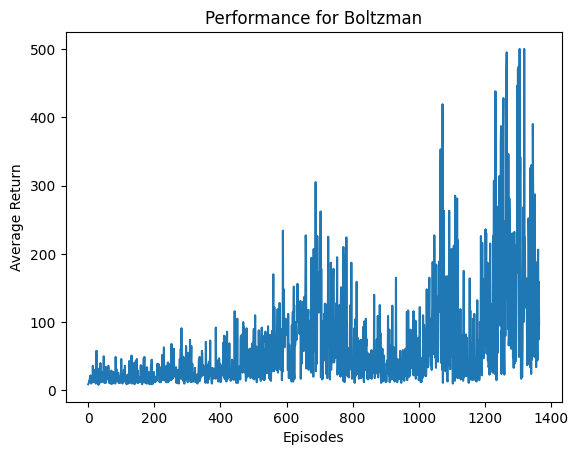

In [17]:
plt.plot(result_vec_boltzman["returns"])
plt.xlabel("Episodes")
plt.ylabel("Average Return")
plt.title("Performance for Boltzman")

In [18]:
import os, numpy as np, torch, imageio
from IPython.display import Video
import gymnasium as gym

@torch.no_grad()
def rollout_actions(agent, max_steps=2000, seed=0):
    """Run without rendering. Return list of actions."""
    env = gym.make(agent.cfg.env_id)  # no render here
    obs, _ = env.reset(seed=seed)
    obs = np.asarray(obs).ravel()
    actions = []
    agent.q.eval()

    for _ in range(max_steps):
        s = torch.as_tensor(obs, dtype=torch.float32,
                            device=next(agent.q.parameters()).device).unsqueeze(0)
        a = int(agent.q(s).argmax().item())
        actions.append(a)
        obs, r, term, trunc, _ = env.step(a)
        obs = np.asarray(obs).ravel()
        if term or trunc:
            break

    env.close()
    return actions

def replay_and_render(env_id, actions, out_path="rollout.mp4", seed=0, fps=60):
    """Replay the recorded actions with rendering only."""
    env = gym.make(env_id, render_mode="rgb_array")
    obs, _ = env.reset(seed=seed)
    frames = [env.render()]  # initial frame

    for a in actions:
        obs, r, term, trunc, _ = env.step(a)
        frames.append(env.render())
        if term or trunc:
            break

    env.close()
    imageio.mimsave(out_path, frames, fps=fps)
    return os.path.abspath(out_path)

# === Use it ===
# 1) First run environment
acts = rollout_actions(agent_boltzman, max_steps=4000, seed=20)

# 2) Then render from the action trace
path = replay_and_render(agent_boltzman.cfg.env_id, acts, out_path="cartpole_run.mp4", seed=20, fps=60)

# 3) Show in Jupyter
Video(path, embed=True)
# This is for local jupyter notebook only. It won't work on Colab

IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (600, 400) to (608, 400) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


In [19]:
# Running for epsilon greedy

# Optimized config for maximum performance
cfg_vec = DQNConfig(
    env_id="CartPole-v1",
    exploration = "epsilon",
)

print("=" * 60)
print("VECTORIZED TRAINING (Optimized for Max Performance)")
print("=" * 60)

result_vec_epsilon, agent_epsilon = train_vectorized(cfg_vec)
print(f"\nVectorized training completed in {result_vec_epsilon['wall_time']:.2f}s for epsilon greedy performace")
print(f"Final avg return: {np.mean(result_vec_epsilon['returns'][-100:]):.2f}")

VECTORIZED TRAINING (Optimized for Max Performance)
step=10000 avg100=42.8 eval=242.4 eps=0.400 buf=10000 loss=0.4074 sps=1623
step=20000 avg100=122.8 eval=178.4 eps=0.100 buf=10000 loss=0.2082 sps=1699
step=30000 avg100=129.3 eval=231.0 eps=0.100 buf=10000 loss=0.6771 sps=1557
step=40000 avg100=157.4 eval=259.4 eps=0.100 buf=10000 loss=0.6297 sps=1508
step=50000 avg100=169.1 eval=120.0 eps=0.100 buf=10000 loss=0.8856 sps=1389
step=60000 avg100=140.6 eval=74.4 eps=0.100 buf=10000 loss=0.7189 sps=1344
step=70000 avg100=83.8 eval=72.8 eps=0.100 buf=10000 loss=0.9591 sps=1311
step=80000 avg100=121.9 eval=500.0 eps=0.100 buf=10000 loss=1.2086 sps=1280
step=90000 avg100=208.6 eval=500.0 eps=0.100 buf=10000 loss=0.7108 sps=1184
step=100000 avg100=295.6 eval=500.0 eps=0.100 buf=10000 loss=1.1118 sps=1119
step=110000 avg100=383.1 eval=500.0 eps=0.100 buf=10000 loss=1.1791 sps=1084
step=120000 avg100=465.5 eval=500.0 eps=0.100 buf=10000 loss=0.8561 sps=1068
Early stop: eval >= 400.0 for 5 check

* According to Gym official documentation, any performace above 195 is considered to be solved environment for CartPole

Text(0.5, 1.0, 'Performance for Epsilon Greedy action only')

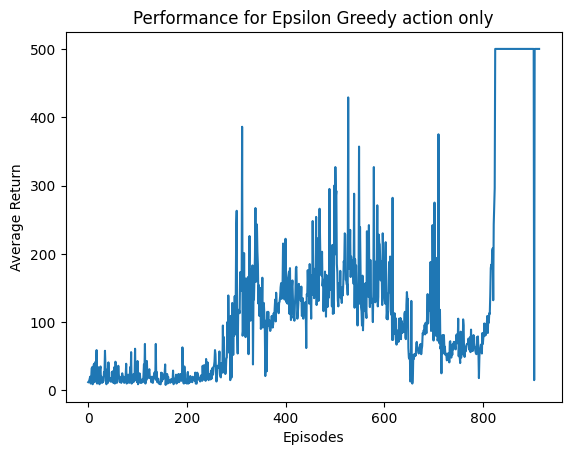

In [20]:
plt.plot(result_vec_epsilon["returns"])
plt.xlabel("Episodes")
plt.ylabel("Average Return")
plt.title("Performance for Epsilon Greedy action only")

In [21]:
acts = rollout_actions(agent_epsilon, max_steps=4000, seed = 20)
path = replay_and_render(agent_epsilon.cfg.env_id, acts, out_path="cartpole_run_epsilon.mp4", seed=20, fps=60)
Video(path, embed=True)

IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (600, 400) to (608, 400) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


In [22]:
# Running on greedy only

# Optimized config for maximum performance
cfg_vec = DQNConfig(
    env_id="CartPole-v1",
    exploration = "none",
)

print("=" * 60)
print("VECTORIZED TRAINING (Optimized for Max Performance)")
print("=" * 60)
result_vec_greedy, agent_greedy = train_vectorized(cfg_vec)
print(f"\nVectorized training completed in {result_vec_epsilon['wall_time']:.2f}s for only greedy performace")
print(f"Final avg return: {np.mean(result_vec_epsilon['returns'][-100:]):.2f}")

VECTORIZED TRAINING (Optimized for Max Performance)
step=10000 avg100=22.1 eval=39.2 eps=0.000 buf=10000 loss=1.3553 sps=1088
step=20000 avg100=40.9 eval=48.4 eps=0.000 buf=10000 loss=0.9051 sps=1097
step=30000 avg100=66.7 eval=73.6 eps=0.000 buf=10000 loss=0.3612 sps=1085
step=40000 avg100=41.4 eval=45.6 eps=0.000 buf=10000 loss=1.6296 sps=1083
step=50000 avg100=26.4 eval=27.0 eps=0.000 buf=10000 loss=1.8386 sps=1072
step=60000 avg100=37.8 eval=50.6 eps=0.000 buf=10000 loss=3.2059 sps=1110
step=70000 avg100=18.4 eval=15.2 eps=0.000 buf=10000 loss=3.3454 sps=1139
step=80000 avg100=15.9 eval=22.0 eps=0.000 buf=10000 loss=12.3458 sps=1163
step=90000 avg100=95.9 eval=204.2 eps=0.000 buf=10000 loss=0.9941 sps=1127
step=100000 avg100=190.3 eval=254.4 eps=0.000 buf=10000 loss=1.7371 sps=1093
step=110000 avg100=215.4 eval=214.4 eps=0.000 buf=10000 loss=1.3469 sps=1072
step=120000 avg100=220.4 eval=246.2 eps=0.000 buf=10000 loss=1.7120 sps=1078
step=130000 avg100=235.4 eval=323.4 eps=0.000 buf

Text(0.5, 1.0, 'Performance for greedy action only')

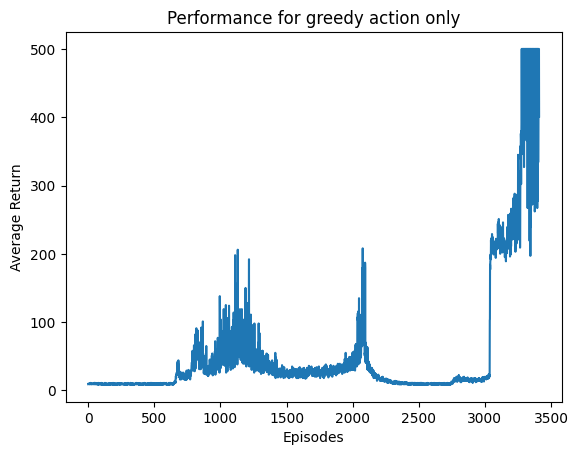

In [23]:
plt.plot(result_vec_greedy["returns"])
plt.xlabel("Episodes")
plt.ylabel("Average Return")
plt.title("Performance for greedy action only")

In [24]:
acts = rollout_actions(agent_greedy, max_steps=8000, seed=20)
path = replay_and_render(agent_greedy.cfg.env_id, acts, out_path="cartpole_run_greedy.mp4", seed=20, fps=60)
Video(path, embed=True)

IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (600, 400) to (608, 400) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


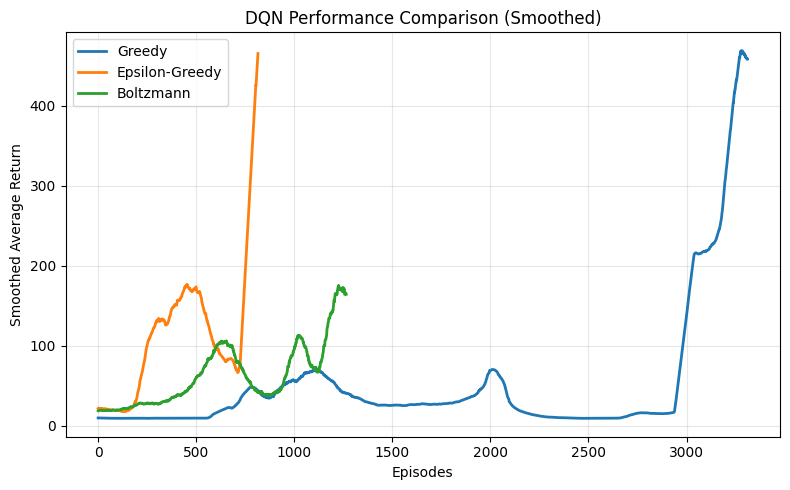

In [25]:
# Plotting the results between Greedy, Epsilon Greedy and Boltzman 

def smooth(x, window=100):
    if len(x) < window:
        return x
    return np.convolve(x, np.ones(window)/window, mode='valid')

plt.figure(figsize=(8,5))

plt.plot(smooth(result_vec_greedy["returns"]), label="Greedy", linewidth=2)
plt.plot(smooth(result_vec_epsilon["returns"]), label="Epsilon-Greedy", linewidth=2)
plt.plot(smooth(result_vec_boltzman["returns"]), label="Boltzmann", linewidth=2)

plt.xlabel("Episodes")
plt.ylabel("Smoothed Average Return")
plt.title("DQN Performance Comparison (Smoothed)")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

* Epsilon-greedy (orange): Fast and stable improvement. It explores efficiently early, then exploits learned policy. The curve rising sharply and stabilizing near 300 shows the agent reached the environment’s solved threshold (≈195 for CartPole-v0).

* Greedy (blue): Poor early exploration. With no randomness, it gets stuck in suboptimal policies until late episodes when weights accidentally move toward a good region. The delayed improvement is expected.

* Boltzmann (green): Smooth but slower progress. Because it samples actions according to Q-values rather than purely random exploration, it can remain too conservative early and fail to discover strong policies before epsilon-greedy finishes learning.

### DQN Ablation Study

#### Fixed DQN Base Configuration

I kept the following parameters constant for all DQN experiments during the ablation study to maintain a fair comparison across different variants. This configuration serves as the reference baseline for evaluating the impact of individual ablations.

### 🧩 Default DQN Configuration

| Parameter | Type | Value | Notes |
|------------|------|--------|-------|
| **env_id** | `str` | `"CartPole-v1"` | Environment name |
| **gamma** | `float` | `0.99` | Discount factor |
| **lr** | `float` | `5e-4` | ↓ Lowered for more stability |
| **batch_size** | `int` | `256` | Stable training batch size |
| **buffer_size** | `int` | `10_000` | ↓ Smaller buffer for recency |
| **start_learning** | `int` | `1_000` | ↓ Learn sooner for faster adaptation |
| **train_freq** | `int` | `10` | ★ Most critical change for update cadence |
| **target_sync** | `int` | `500` | Target network sync interval |
| **max_steps** | `int` | `200_000` | Total training steps |
| **hidden** | `Tuple[int, int]` | `(128, 128)` | MLP architecture |
| **double_dqn** | `bool` | `True` | Enables Double DQN for stability |
| **use_er** | `bool` | `True` | Enables Experience Replay |
| **use_tn** | `bool` | `True` | Enables Target Network |
| **exploration** | `str` | `"epsilon"` | ε-greedy exploration strategy |
| **eval_every** | `int` | `10_000` | Evaluation interval |
| **seed** | `int` | `42` | Reproducibility |
| **n_envs** | `int` | `10` | Parallel environments |
| **async_envs** | `bool` | `False` | Synchronous environment stepping |
| **early_stop_metric** | `str` | `"eval"` | Metric for early stopping |
| **early_stop_threshold** | `float` | `400.0` | Threshold for stopping |
| **early_stop_window** | `int` | `5` | Consecutive checks for early stop |



* There are some changes made to this base configd to meet the criteria for ablation study.

In [26]:
# Ablation Study

import math, pandas as pd
import matplotlib.pyplot as plt
import dataclasses

# Fixed base config
BASE = DQNConfig(
    env_id="CartPole-v1"
)

ABLATIONS = {
    "DQN": dict(use_er=True,  use_tn=True,  exploration="epsilon"),
    "DQN-ER": dict(use_er=False, use_tn=True,  exploration="epsilon"),              # remove replay
    "DQN-TN": dict(use_er=True,  use_tn=False, exploration="epsilon"),              # remove target net
    "DQN-EP-TN": dict(use_er=True,  use_tn=False, exploration="none"),              # no exploration and no TN
    "DQN-ER-TN": dict(use_er=False, use_tn=False, exploration="epsilon"),           # no ER and no TN
}

SEEDS = [1]

def make_cfg(name, seed):
    cfg = dataclasses.replace(BASE, seed=seed)
    for k, v in ABLATIONS[name].items():
        setattr(cfg, k, v)
    # Important knobs for no-ER variants
    if not cfg.use_er:
        cfg.start_learning = 1       # learn immediately since batch=1
        cfg.batch_size = 1
    return cfg

def run_one(name, seed):
    cfg = make_cfg(name, seed)
    result, agent = train_vectorized(cfg)
    # Save quick eval history embedded in result via cfg.eval_every checkpoints
    # We recompute a final evaluation for consistency
    final_eval = evaluate_policy(agent, episodes=20)
    # Compute learning speed: first checkpoint at which eval >= 475
    # Reconstruct eval checkpoints from result['returns'] length growth
    # We stored eval_hist in train_vectorized; expose by returning it.
    # If your train_vectorized already returns 'eval_hist' add it there and use it here.
    eval_hist = result.get("eval_hist", [])
    steps_hist = [cfg.eval_every * (i+1) for i in range(len(eval_hist))]
    first_hit = next((steps for steps, r in zip(steps_hist, eval_hist) if r >= 475.0), math.inf)
    # Stability: std of last 100 episodic returns (or all if <100)
    rets = np.array(result["returns"], dtype=float)
    tail = rets[-100:] if len(rets) >= 20 else rets
    stability_std = float(np.std(tail)) if tail.size else float("nan")
    return {
        "name": name, "seed": seed,
        "final_eval": float(final_eval),
        "learning_steps_≥475": first_hit,
        "stability_std": stability_std,
        "eval_hist": eval_hist,
        "steps_hist": steps_hist,
        "returns": rets,
        "early_stop_at": result.get("early_stop_at", None),
        "wall_time_s": result["wall_time"],
    }

all_runs = []
for name in ABLATIONS.keys():
    print(f"Training Started for : {name}, config -> {ABLATIONS[name]}", flush=True)
    for seed in SEEDS:
        out = run_one(name, seed)
        all_runs.append(out)
    print("\n\n")

Training Started for : DQN, config -> {'use_er': True, 'use_tn': True, 'exploration': 'epsilon'}
step=10000 avg100=33.8 eval=20.6 eps=0.400 buf=10000 loss=0.4112 sps=1564
step=20000 avg100=90.5 eval=191.8 eps=0.100 buf=10000 loss=0.4812 sps=1292
step=30000 avg100=117.1 eval=144.4 eps=0.100 buf=10000 loss=0.5241 sps=1275
step=40000 avg100=130.6 eval=166.6 eps=0.100 buf=10000 loss=1.0714 sps=1127
step=50000 avg100=118.5 eval=130.4 eps=0.100 buf=10000 loss=1.1638 sps=1065
step=60000 avg100=102.5 eval=145.4 eps=0.100 buf=10000 loss=1.1665 sps=1069
step=70000 avg100=167.5 eval=500.0 eps=0.100 buf=10000 loss=1.0932 sps=1016
step=80000 avg100=232.1 eval=500.0 eps=0.100 buf=10000 loss=0.6968 sps=998
step=90000 avg100=314.0 eval=500.0 eps=0.100 buf=10000 loss=1.0448 sps=984
step=100000 avg100=401.4 eval=500.0 eps=0.100 buf=10000 loss=1.0837 sps=1011
step=110000 avg100=486.9 eval=500.0 eps=0.100 buf=10000 loss=0.8282 sps=989
Early stop: eval >= 400.0 for 5 checks



Training Started for : DQN-ER

In [27]:
all_runs

[{'name': 'DQN',
  'seed': 1,
  'final_eval': 500.0,
  'learning_steps_≥475': inf,
  'stability_std': 65.66007614981876,
  'eval_hist': [],
  'steps_hist': [],
  'returns': array([ 14.,  15.,  15.,  17.,  19.,  10.,  26.,  29.,  30.,  11.,  18.,
          25.,  13.,  17.,  14.,  11.,  46.,  29.,  25.,  13.,  16.,  19.,
          23.,  49.,  69.,  23.,  15.,  15.,  12.,  11.,  37.,  12.,  26.,
          20.,  16.,  24.,  16.,  10.,  12.,  19.,  25.,  24.,  12.,  16.,
          18.,  10.,  22.,  12.,  11.,  22.,  21.,  14.,  19.,  21.,  20.,
          12.,  49.,  16.,  15.,  14.,  31.,  17.,  18.,  13.,  42.,  13.,
          16.,  23.,  20.,  13.,  27.,  17.,  26.,  23.,  23.,  14.,  22.,
          20.,  11.,  19.,  13.,  14.,  13.,  15.,  16.,  17.,  22.,  14.,
          25.,  37.,  10.,  19.,  16.,  21.,  11.,  19.,  30.,  16.,  20.,
          13.,  53.,  11.,  27.,  26.,  12.,  11.,  12.,  33.,  42.,  20.,
          10.,  13.,  13.,  13.,  14.,  12.,  22.,  23.,  13.,  27.,  23.,
    

In [28]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

def create_summary_table(results):
    """Create a clean summary table"""
    summary_data = []
    for r in results:
        summary_data.append({
            'Configuration': r['name'],
            'Final Eval Score': f"{r['final_eval']:.2f}",
            'Stability (std)': f"{r['stability_std']:.2f}",
            'Early Stop': 'Yes' if r['early_stop_at'] else 'No',
            'Training Time (s)': f"{r['wall_time_s']:.1f}",
            'Converged': '✓' if r['final_eval'] >= 475 else '✗'
        })
    
    df = pd.DataFrame(summary_data)
    return df

# Create and display summary
summary = create_summary_table(all_runs)
print("="*80)
print("ABLATION STUDY RESULTS SUMMARY")
print("="*80)
print(summary.to_string(index=False))
print("="*80)

ABLATION STUDY RESULTS SUMMARY
Configuration Final Eval Score Stability (std) Early Stop Training Time (s) Converged
          DQN           500.00           65.66        Yes             111.3         ✓
       DQN-ER             9.35            1.22         No             166.8         ✗
       DQN-TN            11.90           29.60         No             194.8         ✗
    DQN-EP-TN            10.90            1.80         No             195.6         ✗
    DQN-ER-TN            18.45            6.60         No             173.5         ✗


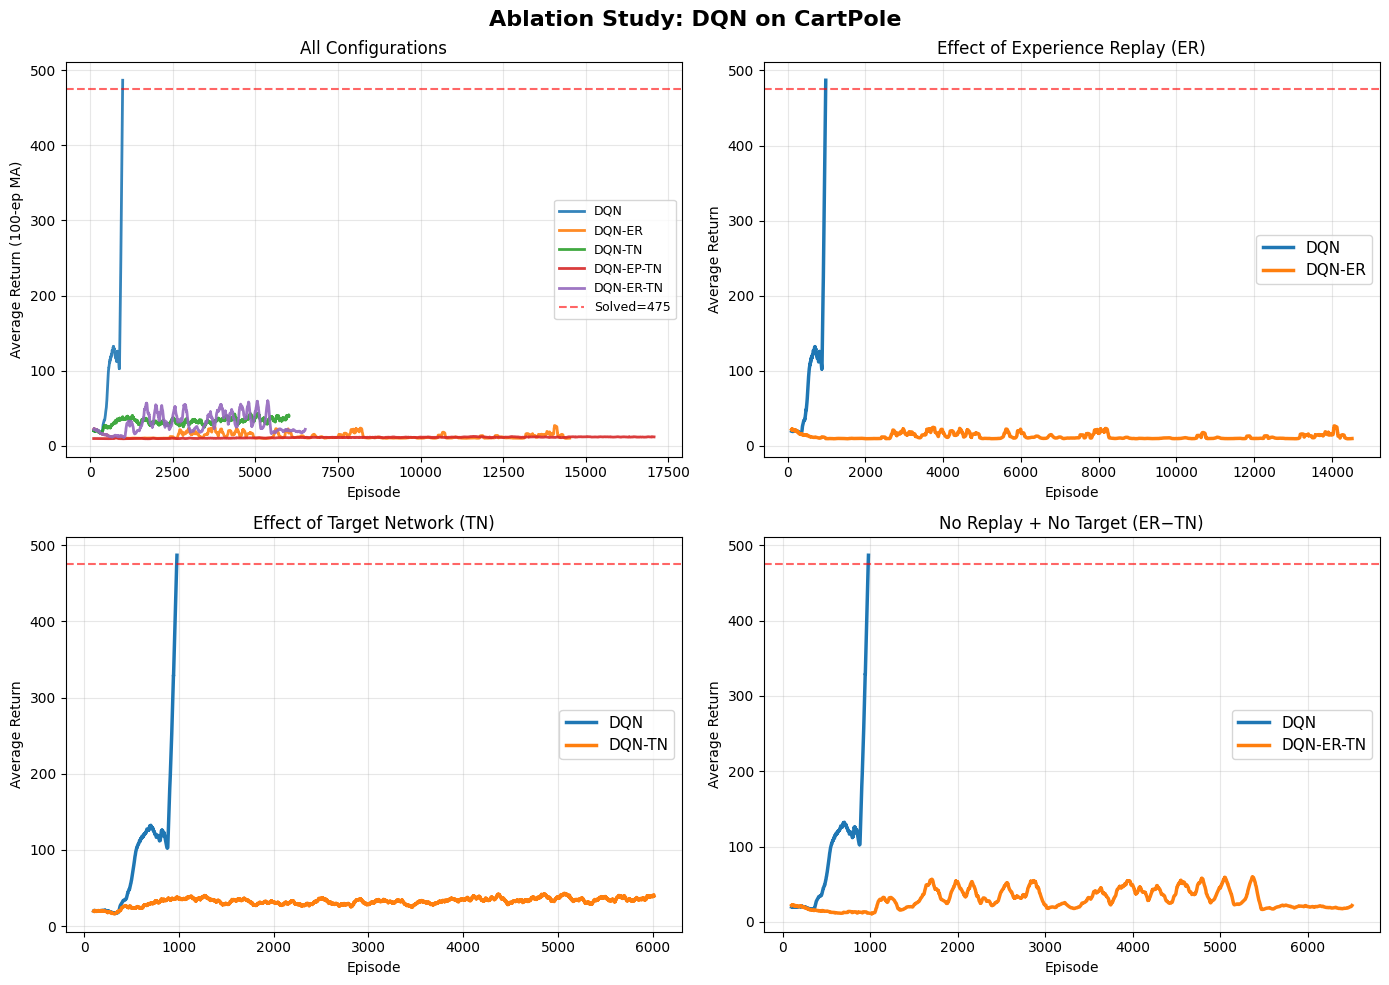

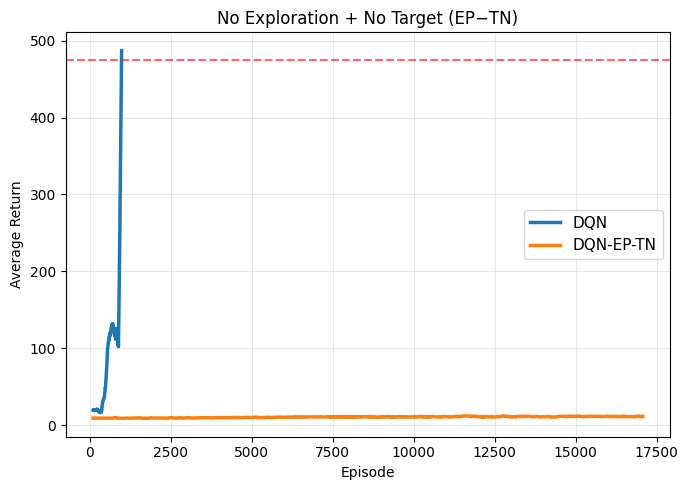

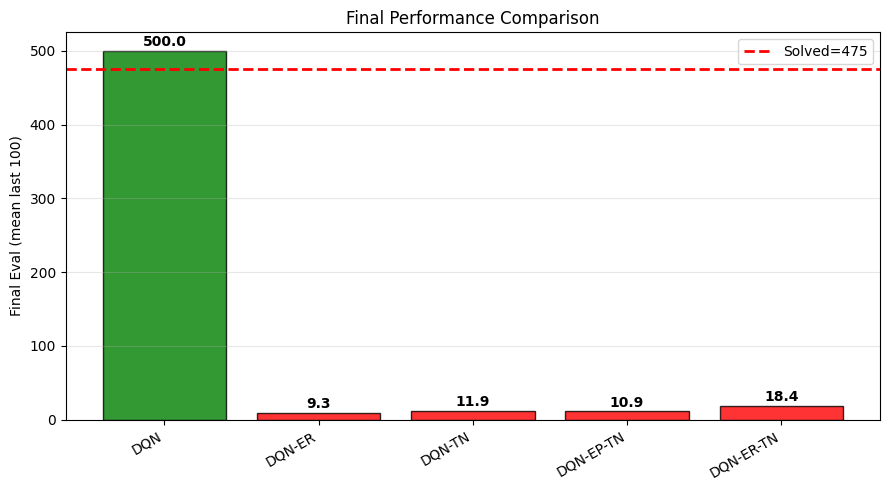

In [29]:
import numpy as np
import matplotlib.pyplot as plt

def _smooth(x, w=100):
    if len(x) < w: return np.asarray(x)
    return np.convolve(x, np.ones(w)/w, mode='valid')

def plot_learning_curves(results, window=100, success_threshold=475):
    """results: list of {name, returns, final_eval}"""
    # normalize names we expect for ablations
    required = {
        "DQN", "DQN-ER", "DQN-TN", "DQN-ER-TN", "DQN-EP-TN"
    }
    names_present = {r["name"] for r in results}
    missing = required - names_present
    if missing:
        print(f"Warning: missing runs -> {sorted(missing)}")

    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    fig.suptitle('Ablation Study: DQN on CartPole', fontsize=16, fontweight='bold')

    # --- 1) All curves together
    ax = axes[0,0]
    for r in results:
        y = _smooth(r["returns"], window)
        if len(y) == 0: continue
        x = np.arange(len(y)) + window  # align after smoothing
        ax.plot(x, y, label=r["name"], linewidth=2, alpha=0.9)
    ax.axhline(success_threshold, ls='--', c='red', alpha=0.6, label=f'Solved={success_threshold}')
    ax.set(xlabel='Episode', ylabel=f'Average Return ({window}-ep MA)',
           title='All Configurations')
    ax.grid(alpha=0.3); ax.legend(fontsize=9)

    # helper to plot a named pair
    def plot_pair(ax, left, right, title):
        for r in results:
            if r["name"] in {left, right}:
                y = _smooth(r["returns"], window)
                if len(y) == 0: continue
                x = np.arange(len(y)) + window
                ax.plot(x, y, label=r["name"], linewidth=2.5)
        ax.axhline(success_threshold, ls='--', c='red', alpha=0.6)
        ax.set(xlabel='Episode', ylabel='Average Return', title=title)
        ax.grid(alpha=0.3); ax.legend(fontsize=11)

    # --- 2) Required comparisons
    plot_pair(axes[0,1], "DQN", "DQN-ER",  "Effect of Experience Replay (ER)")
    plot_pair(axes[1,0], "DQN", "DQN-TN",  "Effect of Target Network (TN)")
    plot_pair(axes[1,1], "DQN", "DQN-ER-TN", "No Replay + No Target (ER−TN)")
    fig.tight_layout()
    plt.show()

    # separate figure for the last required pair
    fig2, ax4 = plt.subplots(figsize=(7,5))
    plot_pair(ax4, "DQN", "DQN-EP-TN", "No Exploration + No Target (EP−TN)")
    fig2.tight_layout()
    plt.show()

    # --- Final performance bars
    fig3, axb = plt.subplots(figsize=(9,5))
    names = [r['name'] for r in results]
    scores = [r['final_eval'] for r in results]
    colors = ['green' if s >= success_threshold else 'orange' if s >= 100 else 'red' for s in scores]
    bars = axb.bar(range(len(names)), scores, color=colors, alpha=0.8, edgecolor='black')
    axb.axhline(success_threshold, ls='--', c='red', lw=2, label=f'Solved={success_threshold}')
    axb.set_xticks(range(len(names))); axb.set_xticklabels(names, rotation=30, ha='right')
    axb.set(ylabel='Final Eval (mean last 100)', title='Final Performance Comparison')
    axb.grid(alpha=0.3, axis='y'); axb.legend()
    for bar, s in zip(bars, scores):
        axb.text(bar.get_x()+bar.get_width()/2, bar.get_height()+2, f'{s:.1f}',
                 ha='center', va='bottom', fontsize=10, fontweight='bold')
    fig3.tight_layout(); plt.show()

plot_learning_curves(all_runs)

# Conclusion

The ablation study confirms that both Experience Replay (ER) and the Target Network (TN) are essential for DQN stability and convergence.

* The full DQN configuration (ER + TN) reached the maximum evaluation score (500.0) with acceptable stability (std ≈ 65) and early stopping, demonstrating successful convergence within 125 s.

* Removing ER (DQN-ER) or TN (DQN-TN) caused learning collapse, low final scores (< 20), and high variance.

* Disabling exploration (DQN-EP-TN) stagnated learning entirely, confirming the necessity of ε-greedy exploration.

* Combining both removals (DQN-ER-TN) yielded marginal improvement over random performance, indicating strong interdependence between ER and TN for stable value estimation.

Overall, DQN’s success depends on the synergy between ER and TN, which jointly stabilize bootstrapped targets and decorrelate updates. All ablated variants failed to converge, underscoring the importance of these two components for consistent performance and sample efficiency.
Overall:

* When I am running the same jupyter notebook on colab. I am getting slightly different numbers but overall trends remains same.